<a href="https://colab.research.google.com/github/thofes/SJ_distance/blob/main/Resnet_Mark1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect GDrive
from google.colab import drive
drive.mount('/content.gdrive')

Mounted at /content.gdrive


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.models import Sequential
# Load the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content.gdrive/MyDrive/Resnet_Data/train",
    subset="training",
    validation_split = 0.2,
    seed=123,
    image_size=(270,480),
    batch_size=32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content.gdrive/MyDrive/Resnet_Data/train",
    subset="validation",
    validation_split = 0.2,
    seed=123,
    image_size=(270,480),
    batch_size=32
)


Found 1998 files belonging to 2 classes.
Using 1599 files for training.
Found 1998 files belonging to 2 classes.
Using 399 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['Flight', 'Landing']


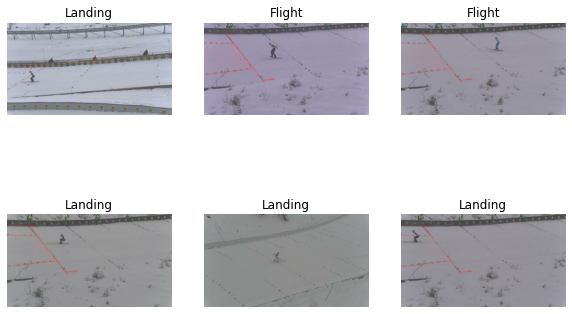

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(270,480,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
epochs=100
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/100
50/50 [==============================] - 18s 340ms/step - loss: 0.1734 - accuracy: 0.9331 - val_loss: 0.3508 - val_accuracy: 0.8496
Epoch 2/100
50/50 [==============================] - 19s 367ms/step - loss: 0.2445 - accuracy: 0.8962 - val_loss: 0.2733 - val_accuracy: 0.8722
Epoch 3/100
50/50 [==============================] - 17s 331ms/step - loss: 0.2217 - accuracy: 0.9081 - val_loss: 0.2844 - val_accuracy: 0.8797
Epoch 4/100
50/50 [==============================] - 17s 328ms/step - loss: 0.1407 - accuracy: 0.9525 - val_loss: 0.2381 - val_accuracy: 0.8872
Epoch 5/100
50/50 [==============================] - 17s 327ms/step - loss: 0.1411 - accuracy: 0.9531 - val_loss: 0.2250 - val_accuracy: 0.8922
Epoch 6/100
50/50 [==============================] - 18s 338ms/step - loss: 0.1221 - accuracy: 0.9625 - val_loss: 0.2559 - val_accuracy: 0.8872
Epoch 7/100
50/50 [==============================] - 17s 332ms/step - loss: 0.1317 - accuracy: 0.9456 - val_loss: 0.2193 - val_accuracy:

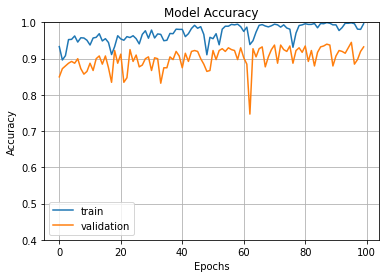

In [26]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

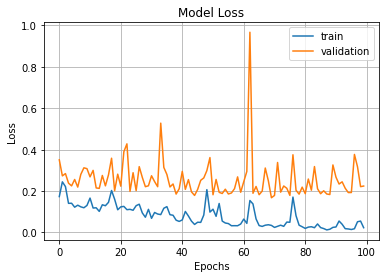

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
resnet_model.save('/content.gdrive/MyDrive/Resnet_Data/resnet_train_140_Epochs.h5')

In [56]:
import cv2
import numpy as np
import os

counter_nok = 0
counter_ok = 0

PATH = '/content.gdrive/MyDrive/Resnet_Data/test/Landing'
label= []
try:
    label = next(os.walk(PATH))[2]
except StopIteration:
    pass
#data["labels"].append(label)
print(label)


for image in label:

    image=cv2.imread('/content.gdrive/MyDrive/Resnet_Data/test/Landing/' + str(image))
    #image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image,axis=0)
    #print(image.shape)



    pred=resnet_model.predict(image)
    print(pred)
        


    output_class=class_names[np.int32(np.around(pred[0,0]))]
    print("The predicted class is", output_class)
    if output_class != 'Landing':
        print("NOK")
        counter_nok+=1
    else:
        counter_ok+=1

print("Von", counter_nok+counter_ok, " Landings wurden ", counter_ok, "richtig erkannt und ", counter_nok, "falsch erkannt")
print("Zu ", 100/(counter_nok+counter_ok)*counter_ok, "% ist das Model korrekt")

        



['10.jpg', '9.jpg', '12.jpg', '11.jpg', '8.jpg', '6.jpg', '5.jpg', '7.jpg', '4.jpg', '3.jpg', '2.jpg', '1.jpg', '21.jpg', '15.jpg', '33.jpg', '16.jpg', '13.jpg', '32.jpg', '31.jpg', '30.jpg', '27.jpg', '28.jpg', '26.jpg', '29.jpg', '25.jpg', '24.jpg', '23.jpg', '22.jpg', '18.jpg', '20.jpg', '14.jpg', '17.jpg', '19.jpg', '66.jpg', '65.jpg', '64.jpg', '63.jpg', '57.jpg', '61.jpg', '59.jpg', '58.jpg', '62.jpg', '60.jpg', '55.jpg', '56.jpg', '54.jpg', '50.jpg', '48.jpg', '53.jpg', '49.jpg', '52.jpg', '47.jpg', '45.jpg', '46.jpg', '51.jpg', '43.jpg', '44.jpg', '42.jpg', '34.jpg', '35.jpg', '39.jpg', '37.jpg', '36.jpg', '38.jpg', '40.jpg', '41.jpg', '96.jpg', '94.jpg', '95.jpg', '93.jpg', '88.jpg', '89.jpg', '91.jpg', '92.jpg', '90.jpg', '86.jpg', '84.jpg', '87.jpg', '85.jpg', '80.jpg', '73.jpg', '83.jpg', '82.jpg', '81.jpg', '76.jpg', '75.jpg', '77.jpg', '78.jpg', '79.jpg', '74.jpg', '71.jpg', '72.jpg', '68.jpg', '70.jpg', '69.jpg', '67.jpg', '129.jpg', '126.jpg', '123.jpg', '124.jpg', '125

In [29]:
import cv2
import numpy as np
import os

counter_nok = 0
counter_ok = 0

PATH = '/content.gdrive/MyDrive/Resnet_Data/test/Flight'
label= []
try:
    label = next(os.walk(PATH))[2]
except StopIteration:
    pass
#data["labels"].append(label)
print(label)


for image in label:

    image=cv2.imread('/content.gdrive/MyDrive/Resnet_Data/test/Flight/' + str(image))
    #image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image,axis=0)
    #print(image.shape)



    pred=resnet_model.predict(image)
    print(pred)
        


    output_class=class_names[np.int32(np.around(pred[0,0]))]
    print("The predicted class is", output_class)
    if output_class != 'Flight':
        print("NOK")
        counter_nok+=1
    else:
        counter_ok+=1

print("Von", counter_nok+counter_ok, " Landings wurden ", counter_ok, "richtig erkannt und ", counter_nok, "falsch erkannt")
print("Zu ", 100/(counter_nok+counter_ok)*counter_ok, "% ist das Model korrekt")

        



['11.jpg', '9.jpg', '7.jpg', '8.jpg', '6.jpg', '5.jpg', '2.jpg', '10.jpg', '4.jpg', '3.jpg', '1.jpg', '40.jpg', '41.jpg', '34.jpg', '33.jpg', '38.jpg', '35.jpg', '36.jpg', '37.jpg', '32.jpg', '39.jpg', '28.jpg', '29.jpg', '30.jpg', '23.jpg', '25.jpg', '24.jpg', '26.jpg', '31.jpg', '27.jpg', '22.jpg', '20.jpg', '21.jpg', '18.jpg', '17.jpg', '16.jpg', '19.jpg', '15.jpg', '14.jpg', '13.jpg', '12.jpg', '66.jpg', '68.jpg', '71.jpg', '64.jpg', '67.jpg', '70.jpg', '65.jpg', '63.jpg', '62.jpg', '69.jpg', '59.jpg', '58.jpg', '61.jpg', '57.jpg', '60.jpg', '54.jpg', '53.jpg', '56.jpg', '55.jpg', '52.jpg', '50.jpg', '51.jpg', '49.jpg', '48.jpg', '47.jpg', '45.jpg', '46.jpg', '44.jpg', '42.jpg', '43.jpg', '99.jpg', '100.jpg', '101.jpg', '98.jpg', '96.jpg', '97.jpg', '95.jpg', '85.jpg', '94.jpg', '92.jpg', '93.jpg', '89.jpg', '88.jpg', '90.jpg', '91.jpg', '86.jpg', '87.jpg', '83.jpg', '82.jpg', '84.jpg', '81.jpg', '79.jpg', '80.jpg', '78.jpg', '75.jpg', '77.jpg', '76.jpg', '74.jpg', '72.jpg', '73.jp

In [70]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt



for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:

    Path_Pic = '/content.gdrive/MyDrive/Data_Pseudolabel/hd4_runno/1001/' + str(i) + '.jpg'
    image = Image.open(Path_Pic)

      # Berechnen Sie die neue Größe
    width, height = image.size
    new_width = width // 2
    new_height = height // 2
      # Skalieren Sie das Bild
    image = image.resize((new_width, new_height), Image.ANTIALIAS)
    #image.save('/content.gdrive/MyDrive/Data_Pseudolabel/hd4_runno/1001/' + str(i) + '.jpg')

    #image2=cv2.imread('content.gdrive/MyDrive/Data_Pseudolabel/hd4_runno/1001/' + str(i) + '.jpg')
    image=np.expand_dims(image,axis=0)
    pred=resnet_model.predict(image2)
    print(pred)
            


    output_class=class_names[np.int32(np.around(pred[0,0]))]
    print("The predicted class is", output_class)



        



1/1 [==============================] - 0s 47ms/step
[[1.01875095e-08]]
The predicted class is Flight
1/1 [==============================] - 0s 40ms/step
[[8.312996e-09]]
The predicted class is Flight
1/1 [==============================] - 0s 109ms/step
[[2.085621e-09]]
The predicted class is Flight
1/1 [==============================] - 0s 140ms/step
[[2.3221726e-10]]
The predicted class is Flight
1/1 [==============================] - 0s 26ms/step
[[5.806799e-11]]
The predicted class is Flight
1/1 [==============================] - 0s 30ms/step
[[1.6734024e-10]]
The predicted class is Flight
1/1 [==============================] - 0s 37ms/step
[[7.591977e-11]]
The predicted class is Flight
1/1 [==============================] - 0s 29ms/step
[[1.2571997e-09]]
The predicted class is Flight
1/1 [==============================] - 0s 29ms/step
[[7.884183e-09]]
The predicted class is Flight
1/1 [==============================] - 0s 27ms/step
[[6.6392275e-08]]
The predicted class is Flight
1/

In [37]:
import cv2
import numpy as np
import os
from PIL import Image

counter_nok = 0
counter_ok = 0

PATH = '/content.gdrive/MyDrive/Vorselektion/B-Hofen_Samples/30'
label= []
try:
    label = next(os.walk(PATH))[2]
except StopIteration:
    pass
#data["labels"].append(label)
print(label)


for image in label:

    #image=cv2.imread('/content.gdrive/MyDrive/Resnet_Data/test/Flight/' + str(image))
    image = Image.open('/content.gdrive/MyDrive/Vorselektion/B-Hofen_Samples/30/' + str(image))
    # Berechnen Sie die neue Größe
    width, height = image.size
    new_width = width // 2
    new_height = height // 2

    # Skalieren Sie das Bild
    image = image.resize((new_width, new_height), Image.ANTIALIAS)

    #image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image,axis=0)
    #print(image.shape)
    



    pred=resnet_model.predict(image)
    print(pred)
        


    output_class=class_names[np.int32(np.around(pred[0,0]))]
    print("The predicted class is", output_class)
    if output_class == 'Landing':
        x = 1/0
        counter_nok+=1
    else:
        counter_ok+=1


        



['Cam1_0007.jpg', 'Cam4_0000.jpg', 'Cam4_0001.jpg', 'Cam1_0001.jpg', 'Cam3_0004.jpg', 'Cam2_0001.jpg', 'Cam2_0006.jpg', 'Cam3_0001.jpg', 'Cam3_0005.jpg', 'Cam1_0002.jpg', 'Cam2_0005.jpg', 'Cam3_0007.jpg', 'Cam4_0005.jpg', 'Cam2_0002.jpg', 'Cam4_0004.jpg', 'Cam2_0007.jpg', 'Cam3_0002.jpg', 'Cam1_0003.jpg', 'Cam1_0006.jpg', 'Cam3_0003.jpg', 'Cam1_0004.jpg', 'Cam2_0003.jpg', 'Cam1_0005.jpg', 'Cam3_0006.jpg', 'Cam4_0006.jpg', 'Cam4_0007.jpg', 'Cam4_0002.jpg', 'Cam4_0003.jpg', 'Cam2_0000.jpg', 'Cam3_0000.jpg', 'Cam2_0004.jpg', 'Cam1_0000.jpg', 'Cam4_0028.jpg', 'Cam4_0022.jpg', 'Cam4_0037.jpg', 'Cam2_0058.jpg', 'Cam3_0021.jpg', 'Cam3_0018.jpg', 'Cam1_0049.jpg', 'Cam1_0012.jpg', 'Cam4_0011.jpg', 'Cam2_0013.jpg', 'Cam4_0062.jpg', 'Cam2_0020.jpg', 'Cam3_0024.jpg', 'Cam1_0008.jpg', 'Cam2_0041.jpg', 'Cam4_0012.jpg', 'Cam1_0040.jpg', 'Cam4_0049.jpg', 'Cam3_0016.jpg', 'Cam1_0045.jpg', 'Cam4_0015.jpg', 'Cam3_0062.jpg', 'Cam1_0057.jpg', 'Cam4_0047.jpg', 'Cam3_0008.jpg', 'Cam4_0067.jpg', 'Cam1_0061.jp

Ab hier nur Tests!!!

In [ ]:



def resnet_block(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=(3,3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def ResNet(input_shape=(400,400,3), classes=2):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3,3), strides=2)(x)
    
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)
    
    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, x, name='resnet')
    return model

model = ResNet()
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])






Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 200, 200, 64)      0         
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 99, 64)        36928

In [ ]:

#Test Konfig BA

!pip install -U tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping     

def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim


save_callback = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
def scheduler(epoche, lr):
      if epoche < 2:
          return lr
      else:
          return lr*0.97
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
#model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer=Ranger(), loss='binary_crossentropy', metrics=['accuracy'])


epochs=40
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True,
  callbacks=[save_callback]
)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [ ]:
model.fit(train_ds, batch_size=32, epochs=100,validation_data=val_ds)
#print(train_ds)

Epoch 1/100
25/25 [==============================] - 13s 498ms/step - loss: 0.7397 - accuracy: 0.6508 - val_loss: 32.7901 - val_accuracy: 0.5126
Epoch 2/100
25/25 [==============================] - 13s 497ms/step - loss: 0.6058 - accuracy: 0.7497 - val_loss: 4.5129 - val_accuracy: 0.6231
Epoch 3/100
25/25 [==============================] - 13s 495ms/step - loss: 0.6324 - accuracy: 0.6571 - val_loss: 71.3371 - val_accuracy: 0.5327
Epoch 4/100
25/25 [==============================] - 13s 491ms/step - loss: 0.6158 - accuracy: 0.7472 - val_loss: 57.5172 - val_accuracy: 0.5276
Epoch 5/100
25/25 [==============================] - 13s 491ms/step - loss: 0.6330 - accuracy: 0.7610 - val_loss: 50.2452 - val_accuracy: 0.4824
Epoch 6/100
25/25 [==============================] - 13s 493ms/step - loss: 0.5434 - accuracy: 0.7860 - val_loss: 2.4300 - val_accuracy: 0.5226
Epoch 7/100
25/25 [==============================] - 13s 495ms/step - loss: 0.4608 - accuracy: 0.7735 - val_loss: 2.3505 - val_accur

In [ ]:
model.save('/content.gdrive/MyDrive/Data_Resnet_VAL/resnet_big_100_Epochs.h5')

The image_dataset_from_directory function takes in the path to the directory containing the images, the validation split, and the image size you want to use. It automatically labels the images based on the directory structure, so the images in the same directory are considered to be of the same class.

The function returns a tf.data.Dataset object that can be used to train the model. The map function is used to apply normalization to the data. The data is also shuffled and batched to improve performance during training.

You can also use tf.keras.preprocessing.image.ImageDataGenerator class to load and preprocess the images, this class also provides data augmentation techniques which can be useful to improve the performance of the model.

- path/to/train_data
    - in_air
        - image1.jpg
        - image2.jpg
        - ...
    - on_ground
        - image1.jpg
        - image2.jpg
        - ...

oder:
  - path/to/train_data
    - train
        - in_air
            - image1.jpg
            - image2.jpg
            - ...
        - on_ground
            - image1.jpg
            - image2.jpg
            - ...
    - validation
        - in_air
            - image1.jpg
            - image2.jpg
            - ...
        - on_ground
            - image1.jpg
            - image2.jpg
            - ...

  
  You can use any image file format that is supported by TensorFlow, such as JPG or PNG. Make sure that all images have the same size (256x256 in this case).

Finally, if you have images in different file format or size, you can use libraries such as OpenCV to convert them to the appropriate format and size before using the function to load them.

In [ ]:
model.save('resnet.h5')